# Credit Risk Analysis

# Convert this cell to code if we need to reinstall qiskit_aer
!python -m pip uninstall qiskit_aer --yes
!python -m pip install qiskit_aer
!pip install qiskit-finance

In [24]:
import CRA_util
import CRA_ExperimentOnAE

In [60]:
#basic python libraries for math and visualization
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Finance
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel 

#Qiskit libraries for our code
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit.algorithms import EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction


In [66]:
# set parameters for the Gaussian Conditional Independence model
n_z = 3 # number of qubits used to repsent latent variabl z 
z_max = 2 #z sample
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25,0.1]
rhos = [0.1, 0.05,0.1] # sensitivity
uncertinitiyModel = GaussianConditionalIndependenceModel(n_z, z_max, p_zeros, rhos)

In [67]:
uncertinitiyModel.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

In [68]:
u_measure = uncertinitiyModel.measure_all(inplace=False)
#print(u_measure)
sampler = Sampler()
job = sampler.run(u_measure)
bprobabilities = job.result().quasi_dists[0].binary_probabilities()
print(bprobabilities)
print(len(bprobabilities))
#counts = job.result()
#print(counts)

{'011100': 0.0068359375, '111010': 0.001953125, '001000': 0.001953125, '100001': 0.0048828125, '111001': 0.0009765625, '100000': 0.001953125, '110000': 0.0009765625, '011011': 0.009765625, '001011': 0.0166015625, '001001': 0.01171875, '111011': 0.001953125, '000001': 0.0283203125, '100101': 0.00390625, '000101': 0.1416015625, '110001': 0.0048828125, '011101': 0.001953125, '000000': 0.0146484375, '100100': 0.01171875, '101010': 0.0029296875, '010010': 0.0341796875, '000110': 0.072265625, '100010': 0.0126953125, '010110': 0.0107421875, '010111': 0.001953125, '010001': 0.0205078125, '110010': 0.0068359375, '101011': 0.001953125, '000111': 0.021484375, '010100': 0.046875, '110011': 0.0078125, '111000': 0.001953125, '000010': 0.072265625, '100111': 0.0009765625, '101100': 0.0009765625, '000011': 0.1240234375, '101001': 0.0029296875, '010000': 0.005859375, '011001': 0.005859375, '010101': 0.0244140625, '001101': 0.0126953125, '001110': 0.001953125, '010011': 0.052734375, '100011': 0.01171875

In [77]:
# analyze uncertainty circuit and determine exact solutions
K = len(p_zeros)
lgd = [1, 2,1] # loss of each asset
alpha = 0.05 #confidence level (VaR or CVaR)
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertinitiyModel.num_qubits
print("K assets",K)
print(num_qubits,K,p_default,p_z)
for i, prob in bprobabilities.items():
    
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob
    
    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]
    print(i,i[-n_z:],i_normal,p_z) #,values,probabilities)

print(values,probabilities)
values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
print(losses)
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)
print(pdf)
print(cdf)
i_var = np.argmax(cdf >= 1 - alpha)
print(i_var)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

K assets 3
6 3 [0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0.]
011100 100 4 [0.         0.         0.         0.         0.00683594 0.
 0.         0.        ]
111010 010 2 [0.         0.         0.00195312 0.         0.00683594 0.
 0.         0.        ]
001000 000 0 [0.00195312 0.         0.00195312 0.         0.00683594 0.
 0.         0.        ]
100001 001 1 [0.00195312 0.00488281 0.00195312 0.         0.00683594 0.
 0.         0.        ]
111001 001 1 [0.00195312 0.00585938 0.00195312 0.         0.00683594 0.
 0.         0.        ]
100000 000 0 [0.00390625 0.00585938 0.00195312 0.         0.00683594 0.
 0.         0.        ]
110000 000 0 [0.00488281 0.00585938 0.00195312 0.         0.00683594 0.
 0.         0.        ]
011011 011 3 [0.00488281 0.00585938 0.00195312 0.00976562 0.00683594 0.
 0.         0.        ]
001011 011 3 [0.00488281 0.00585938 0.00195312 0.02636719 0.00683594 0.
 0.         0.        ]
001001 001 1 [0.00488281 0.01757812 0.00195312 0.02636719 0.00683594 0.
 0.         

In [78]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                0.7441
Value at Risk VaR[L]:              3.0000
P[L <= VaR[L]]:                    0.9932
Conditional Value at Risk CVaR[L]: 4.0000


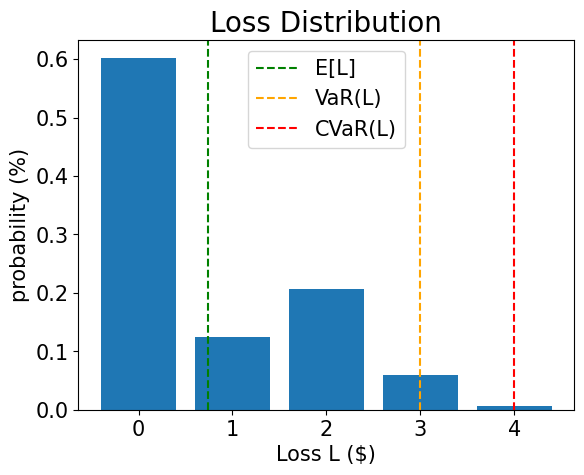

In [79]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

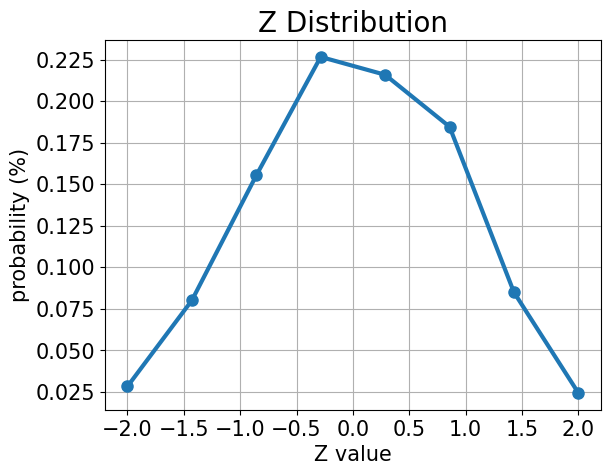

In [80]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

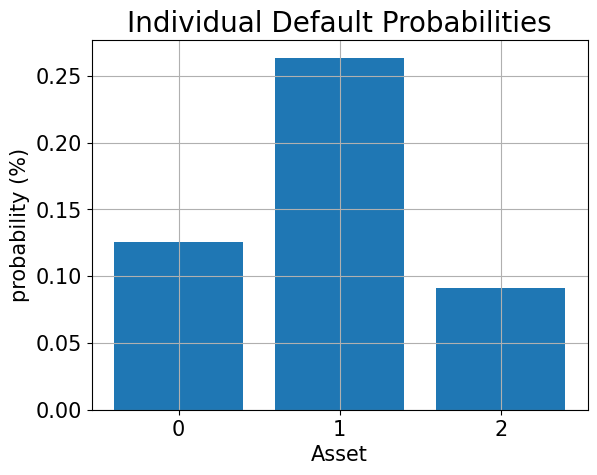

In [81]:
# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [82]:
# add Z qubits with weight/loss
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [83]:
# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [84]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertinitiyModel.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
print("Total Qubits used:", uncertinitiyModel.num_qubits + agg.num_sum_qubits+ agg.num_carry_qubits + 1)
# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(uncertinitiyModel.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

Total Qubits used: 12


CircuitError: 'The amount of qubit(11)/clbit(0) arguments does not match the gate expectation (12).'

In [33]:
state_preparation.decompose().draw()

┌───────┐┌──────────────┐      ┌─────────────────┐
  state_0: ┤0      ├┤0             ├──────┤0                ├
           │       ││              │      │                 │
  state_1: ┤1      ├┤1             ├──────┤1                ├
           │  P(X) ││              │      │                 │
  state_2: ┤2      ├┤2             ├──────┤2                ├
           │       ││              │      │                 │
  state_3: ┤3      ├┤3             ├──────┤3                ├
           └───────┘│  circuit-484 │┌────┐│  circuit-484_dg │
objective: ─────────┤              ├┤2   ├┤                 ├
                    │              ││    ││                 │
    sum_0: ─────────┤4             ├┤0 F ├┤4                ├
                    │              ││    ││                 │
    sum_1: ─────────┤5             ├┤1   ├┤5                ├
                    │              │└────┘│                 │
    carry: ─────────┤6             ├──────┤6                ├
                    └──────────────┘      └─────────────────┘

In [34]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [35]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   0.6494
Exact Operator Value:  0.3955
Mapped Operator value: 0.7017


In [36]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
fae = CRA_ExperimentOnAE.FasterAE()
result = fae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.6494
Estimated value:	0.6451
Confidence interval: 	[-1.1447, 3.2214]


In [37]:
# set x value to estimate the CDF
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │  cmp │
compare: ┤2     ├
         │      │
    a44: ┤3     ├
         └──────┘

In [38]:
state_preparation.draw()

┌───────┐┌────────┐      ┌───────────┐
  state_0: ┤0      ├┤0       ├──────┤0          ├
           │       ││        │      │           │
  state_1: ┤1      ├┤1       ├──────┤1          ├
           │  P(X) ││        │      │           │
  state_2: ┤2      ├┤2       ├──────┤2          ├
           │       ││        │      │           │
  state_3: ┤3      ├┤3       ├──────┤3          ├
           └───────┘│  adder │┌────┐│  adder_dg │
objective: ─────────┤        ├┤2   ├┤           ├
                    │        ││    ││           │
    sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                    │        ││    ││           │
    sum_1: ─────────┤5       ├┤1   ├┤5          ├
                    │        │└────┘│           │
    carry: ─────────┤6       ├──────┤6          ├
                    └────────┘      └───────────┘

In [39]:
state_preparation = CRA_util.get_cdf_circuit(x_eval,uncertinitiyModel,agg)

Total Qubits used: 9


In [40]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [41]:
# evaluate the result
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(2) = 0.9551
Exact    CDF(2) = 0.9580


In [42]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
fae_cdf = CRA_ExperimentOnAE.FasterAE()
result_cdf = fae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.9580
Estimated value:	0.9762
Confidence interval: 	[0.5791, 1.4683]


In [43]:
# run bisection search to determine VaR
objective = lambda x: CRA_util.run_ae_for_cdf(x,uncertinitiyModel,agg,qr_state)
bisection_result = CRA_util.bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
Total Qubits used: 9
-1           0.000         1       0.756     3            1.000
Total Qubits used: 9
 1           0.756         2       0.964     3            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [44]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  2
Exact Value at Risk:      2
Estimated Probability:    0.964
Exact Probability:        0.958


In [45]:
# define linear objective
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

cvar_objective.draw()

┌────┐
q218_0: ┤0   ├
        │    │
q218_1: ┤1   ├
        │    │
  q219: ┤2 F ├
        │    │
a121_0: ┤3   ├
        │    │
a121_1: ┤4   ├
        └────┘

In [46]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertinitiyModel.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

print("Total Qubits used:",uncertinitiyModel.num_qubits+agg.num_sum_qubits+
          agg.num_carry_qubits+1+ cvar_objective.num_ancillas - len(qr_carry))
# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")

# load the random variable
state_preparation.append(uncertinitiyModel, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

Total Qubits used: 9


In [47]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [48]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 2.2806
Exact CVaR:     3.0000


In [49]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
fae_cvar = CRA_ExperimentOnAE.FasterAE()
result_cvar = fae_cvar.estimate(problem)

In [50]:
# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	3.0000
Estimated CVaR:	3.8137


#References
1. https://qiskit.org/documentation/stubs/qiskit.algorithms.IterativeAmplitudeEstimation.html
2. https://github.com/qiskit-community/qiskit-finance/blob/stable/0.3/docs/tutorials/00_amplitude_estimation.ipynb
3. https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html
4. https://qiskit.org/documentation/_modules/qiskit/circuit/library/arithmetic/linear_amplitude_function.html
5. 


Papers refered:
https://arxiv.org/pdf/1907.03044.pdf
https://arxiv.org/pdf/1412.1183.pdf
file:///Users/neha/Downloads/s41534-019-0130-6%20(1).pdf
